# Analysis of Donald Trump's Tweets

My team and I are interested in President Donald Trump's tweets from the popular social media platform Twitter because they deliver the opinions and thoughts from this controversial political figure straight to the public. From a website called [Crowdbabble](https://www.crowdbabble.com/about/), which focuses on social media analytics, we were able to retrieve a large CSV file of his tweets from the early days of his 2016 presidential campaign all the way up to his victory in November. These are the question we plan on answering in our final deliverable: 
    1. On average, do Trump's tweets tend to be positive or negative?
    2. What are Trump's most used words in his tweets?
    3. Have Trump’s twitter semantics change over time?

## Data peparation 


In [30]:
# Set-up
import pandas as pd
import numpy as np
import csv as csv
from nltk.tokenize import TweetTokenizer
from collections import OrderedDict, defaultdict, Counter
import seaborn as sns # for visualization
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt # plotting

In [31]:
df = pd.read_csv('./data/Trump-Tweets.csv')
df.columns

Index([u'Tweet_Num', u'Date', u'Text', u'Favorites', u'Retweets'], dtype='object')

Here, I read in the entire CSV file and convert it to a dataframe. I am using Latin-1 for decoding here due to the fact that it is fairly common for tweets to contain special characters that UTF-8 cannot convert. If the encoding parameter is set to 'utf-8' here, python will actually throw an error. Next, I drop the columns that are irrelevant to our analysis to simplify our dataset. They are all metadata about the tweets, and the information we need to focus on are the acutal content of the tweets.

The library we will be utilizing to conduct the sentiment analysis is the [NRC Word-Emotion Association Lexicon](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm), which will help us determine eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust). It will also help us determine whether the tweet is positive or negative. The categorization were manually done by crowdsourcing. These will be our new columns, which provide more information about the content of the tweets. In addition, I have added a variable called "polarity" that calculates the magnitude of the tweet's sentiment, and it is simply subtracting the negative column from the positive column. Last but not least, I added the varible "sentiment" that labels the tweet as positive, negative or neutral based on the polarity.

In [32]:
# Gather and isolate all the tweets
tweets = df['Text']
wordList = defaultdict(list)
emotionList = defaultdict(list)

# Process the text file and put the lexicon into a dictionary.
with open('./data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for word, emotion, present in reader:
        if int(present) == 1:
            wordList[word].append(emotion)
            emotionList[emotion].append(word)
            
tt = TweetTokenizer()

def generate_emotion_count(string, tokenizer):
    emoCount = Counter()
    for token in tt.tokenize(string):
        token = token.lower()
        emoCount += Counter(wordList[token])
    return emoCount

# Go through all the tweets with the lexicon and figure out the emotions and sentiments.
emotionCounts = [generate_emotion_count(tweet, tt) for tweet in tweets]
emotion = pd.DataFrame(emotionCounts, index=tweets.index)

# Fill in 0s if the emotion is not detected.
emotion = emotion.fillna(0)

In [33]:
# Join the original dataset and the sentiment and emotion counts
df = pd.concat([df, emotion], axis=1, join='inner')

# Adds polarity, sentiments and tweet_length columns
df['polarity'] = df['positive'] - df['negative']

sentiments = []
for polarity in df['polarity']:
    if polarity > 0:
       sentiments.append("positive")
    elif polarity < 0:
       sentiments.append("negative")
    else:
       sentiments.append("neutral")
    
df['sentiment'] = sentiments

## Describing the Data Structure

In this section, I want to showcase what the dataset looks like now after some manipulation and cleaning up. Below is the shape of the dataset and the variable type of each column. 

In [34]:
df.shape

(8165, 17)

In [35]:
df.dtypes

Tweet_Num         int64
Date             object
Text             object
Favorites         int64
Retweets          int64
anger           float64
anticipation    float64
disgust         float64
fear            float64
joy             float64
negative        float64
positive        float64
sadness         float64
surprise        float64
trust           float64
polarity        float64
sentiment        object
dtype: object

In the dataset, there are now 7375 Tweets dated from July 16th, 2015 to November 11th, 2016 and 18 columns. Below is a sample of what the dataset looks like now.

In [36]:
df.sample(n=10)

,Tweet_Num,Date,Text,Favorites,Retweets,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity,sentiment
2689,2692,15-11-22,We need Trump now Obama isnt protecting Am...,2691,1172,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,positive
4950,4961,16-04-09,Fugedaboudit The woman in New York love Dona...,14654,4674,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,positive
2871,2875,15-12-03,Via,1594,671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
1644,1645,15-10-10,gorham Go President Trump Many Canadians up h...,1618,730,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,positive
1463,1464,15-10-03,Itd be humorous to cull tweets from experts ...,1606,863,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,-1.0,negative
6434,6445,16-09-01,RT I hear Churchill had a nice turn of phrase...,24599,9074,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,1.0,3.0,positive
2013,2016,15-10-25,this Mexican here loves you man Keep doing y...,1787,774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
724,725,15-08-08,REPORT ROBINSON Establishment didnt get Trump ...,2622,1156,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,negative
2457,2460,15-11-10,Great job on Nobody could have done it better,2497,889,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,positive
7087,7098,16-10-20,RT #CrookedHillarys plan will add 115 TRILLIO...,7526,4075,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,positive


## Univariate Analysis

To answer our second question, we needed to determine the most frequently used words by Trump. To do this, we separated each tweet into individual words and then took a count of each word.

![Trump's Top 10 Most Frequently Used Words](most-common.png)


We then used a library called 'wordcloud' to visualize our data better.

!['Wordcloud Visualization of Trump's Most Used Words'](wordcloud.png)

We are interested in all of the new columns that I have added, along with date, the number of favorites and retweets. We fist want to see the distribution of emotions in his tweets. For some of the emotions, we see a value of 0, and that's because the lexicon does not associate some of Trump's words with an emotion. As we are examining the emotion counts, we are not so interested in the distribution of each emotion because it is almost impossible to pinpoint one emotion for one tweet. In addtion, the emotion columns are more of a tally of how many times that emotion emerges in the tweet. We are more intrigued by the overall distribution of emotions among his 7375 tweets. Below is a histogram of that data.

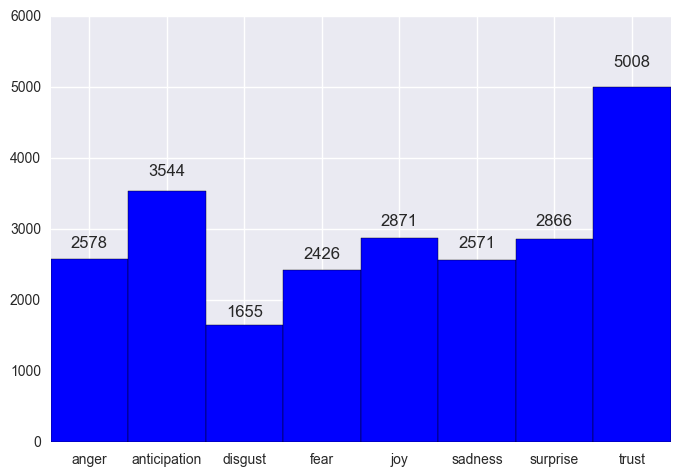

In [10]:
# Histogram of emotions
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
emotion_sums = [sum(df['anger']), sum(df['anticipation']), sum(df['disgust']), sum(df['fear']), sum(df['joy']), sum(df['sadness']), sum(df['surprise']), sum(df['trust'])]

pos = np.arange(len(emotions))
width = 1.0 
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(emotions)

# Graph the histogram
rects = plt.bar(pos, emotion_sums, width, color='b')

# Attach a text label for each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rects)
plt.show()

It is surprising for me that trust receives the highest count. I thought anger or disgust would take the lead because Trump bashes his opponents, the state of our country and President Obama's policies quite often, but perhaps using words that inflict trust is the reason why he has so many loyal supporters. 

Next, we want to examine the distribution of polarity so that we can try to figure out if Trump's emotions and sentiments change overtime. Later in the analysis, we would like to find out major dates during the election and see if we can pinpoint the exact date(s) Trump's emotions and sentiments alter.

In [11]:
df['polarity'].describe()

count    8165.000000
mean        0.323209
std         1.279625
min        -6.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: polarity, dtype: float64

Last but not least, we are also interested in the distrubtion of favorites and retweets. We want to see how sentiment and emotions in Trump's tweet affect people's response on Twitter. Below is a scatter plot between those two columns.

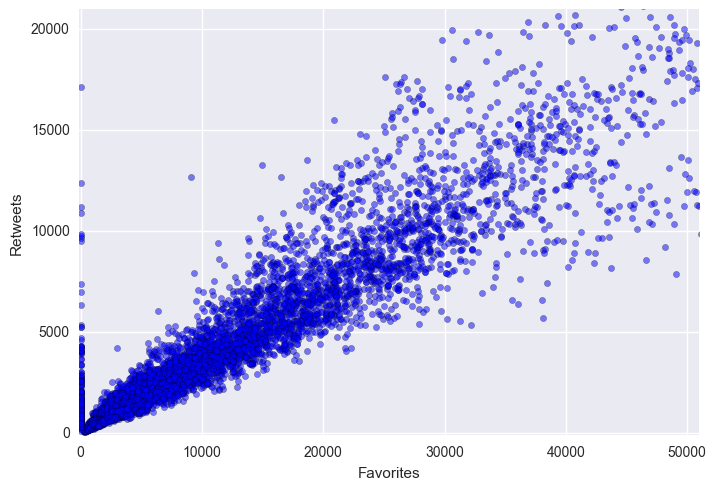

In [12]:
plt.scatter(df['Favorites'], df['Retweets'], alpha=0.5)
plt.xlim(-100, 51000)
plt.ylim(-100, 21000)
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.show()

The relationship looks pretty standard to me. The only suprising trend is that some of the tweets have 0 favorites. I think that occurred because those tweets are actually deleted from Trump's account. I can not find them on his Twitter page.

## Univariate Analysis by Category

I group the observations by sentiment and provide a sample of the data, as well as the number of rows in each grouping. We are not so interested in the neutral tweets because it's hard to determine what side of sentiment it is on. 

In [13]:
positive_tweets = df.groupby('sentiment').get_group('positive')
positive_tweets.sample(n=2)

,Tweet_Num,Date,Text,Favorites,Retweets,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity,sentiment
150,151,15-07-21,Flags to be flown at HalfStaff at all Trump Pr...,3177,1536,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,positive
2576,2579,15-11-17,Great poll numbers out of Thank you #Trump201...,3282,1299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,positive


In [14]:
positive_tweets.shape

(3358, 17)

In [15]:
negative_tweets = df.groupby('sentiment').get_group('negative')
negative_tweets.sample(n=2)

,Tweet_Num,Date,Text,Favorites,Retweets,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity,sentiment
1679,1680,15-10-13,Will be tough as they were with Not sure,1394,663,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,negative
5740,5751,16-06-26,We must suspend immigration from regions linke...,35005,11873,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.0,negative


In [16]:
negative_tweets.shape

(1585, 17)

Next, I graph both set of the dataset to examine the favorite and retweet count in a scatter plot.

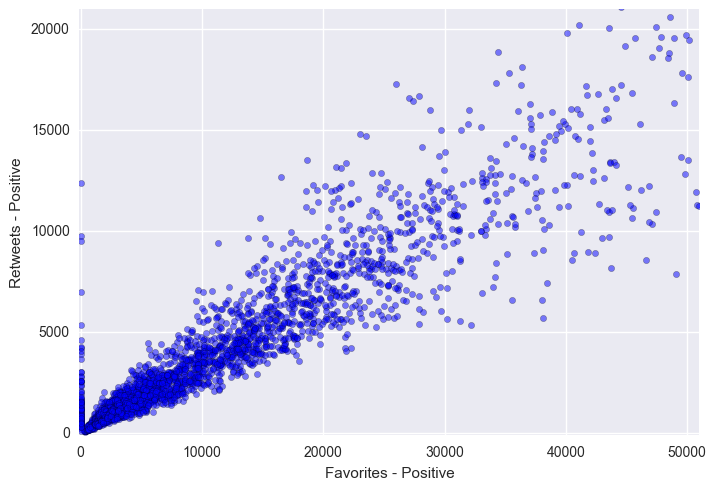

In [17]:
plt.scatter(positive_tweets['Favorites'], positive_tweets['Retweets'], alpha=0.5)
plt.xlim(-100, 51000)
plt.ylim(-100, 21000)
plt.xlabel('Favorites - Positive')
plt.ylabel('Retweets - Positive')
plt.show()

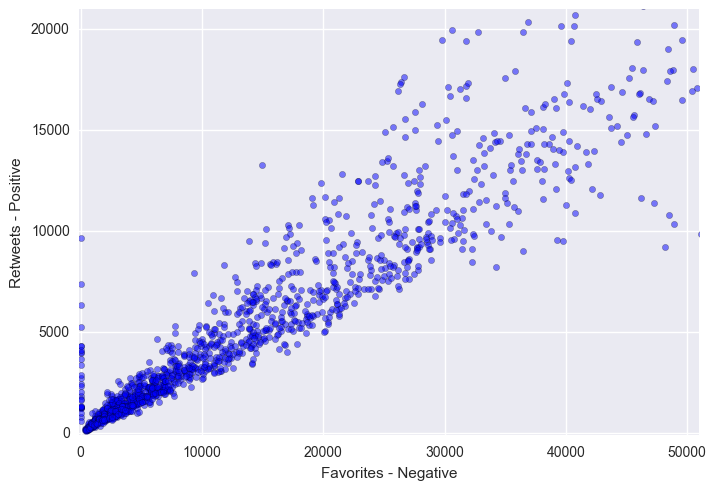

In [30]:
plt.scatter(negative_tweets['Favorites'], negative_tweets['Retweets'], alpha=0.5)
plt.xlim(-100, 51000)
plt.ylim(-100, 21000)
plt.xlabel('Favorites - Negative')
plt.ylabel('Retweets - Positive')
plt.show()

Surprisingly, Trump issued more than double the positive tweets than the negative tweets. However, when he published a negative tweet, the chance of the favorite and retweet count being higher than much greater than a positive tweet.

## Bivariate analysis

For the bivariate analysis, I use the correlation data from the panda library and generate a heat map from the seaborn library to see how the variable covary. I decide to conduct this over the entire dataframe, even though some data might not be relevant, just in case some interesting trend pops up.

In [18]:
df.corr()

,Tweet_Num,Favorites,Retweets,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity
Tweet_Num,1.000000,0.583231,0.530601,0.073896,0.022659,0.047936,0.096024,-0.012950,0.082636,0.014020,0.060119,-0.121790,0.010273,-0.046505
Favorites,0.583231,1.000000,0.895866,0.093647,0.044141,0.079879,0.128372,0.039444,0.122194,0.069911,0.095723,-0.061914,0.062710,-0.031240
Retweets,0.530601,0.895866,1.000000,0.096620,0.018558,0.077048,0.129011,0.014691,0.121908,0.035259,0.093792,-0.066974,0.043102,-0.057484
anger,0.073896,0.093647,0.096620,1.000000,0.171143,0.626407,0.620694,0.118188,0.729193,0.101578,0.653393,0.213901,0.135115,-0.427261
anticipation,0.022659,0.044141,0.018558,0.171143,1.000000,0.067284,0.133885,0.598991,0.142526,0.420231,0.168185,0.389041,0.396646,0.222005
disgust,0.047936,0.079879,0.077048,0.626407,0.067284,1.000000,0.487620,0.026048,0.622289,0.040481,0.569666,0.095019,0.072083,-0.399880
fear,0.096024,0.128372,0.129011,0.620694,0.133885,0.487620,1.000000,0.016559,0.611319,0.049416,0.572460,0.090770,0.087923,-0.385468
joy,-0.012950,0.039444,0.014691,0.118188,0.598991,0.026048,0.016559,1.000000,0.049901,0.617947,0.105668,0.459002,0.543210,0.436994
negative,0.082636,0.122194,0.121908,0.729193,0.142526,0.622289,0.611319,0.049901,1.000000,0.058183,0.746742,0.144957,0.096740,-0.647837
positive,0.014020,0.069911,0.035259,0.101578,0.420231,0.040481,0.049416,0.617947,0.058183,1.000000,0.082592,0.298409,0.617434,0.722796


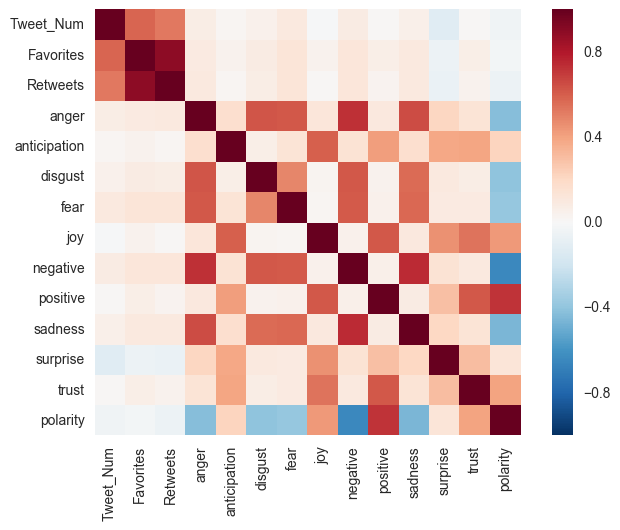

In [19]:
sns.heatmap(df.corr(), square=True)
plt.show()

Although not all the squares are worth examing, I am glad to see that some of the data in this section are consistent with the data from the earlier sections. For example, there is a stronger positive correlation between the negative sentiment and favorite and retweet counts than the positive sentiment. 

## Summary

After this intial data exploratory exercise, many of my assumptions are shattered. I am surprised at how many more positive tweets that Trump sends than negative tweets, as well as finding out that generally, his tweets actually contains many words that inflict trusts. I was very certain that his tweets are going to lean toward the more negative emotions. 

Our group is definitely limited by the lexicon that we are using to analyze Trump's tweets. Perhaps we need to think about using multiple lexicons to see if we are obtaining similar results across the board. We also need to find the data for major dates during the past election to see if we can map out the exact dates his tweet semantic and emotions change. Another item for the actual analysis would be find out his most frequently used word, but that should be a pretty simply loop to configure. I am also worried about my method of calculating the sentiment. Right now, I am simply taking the difference between the positive and negative word counts, but should neutral be when both counts are 0 or is it valid to claim that the tweet is also neutral if the two counts cancel each other out? 